### Predict El Nino Southern Oscillation with CICMoD dataset

In this project we work with **C**limate **I**ndex **C**ollection based on **Mo**del **D**ata (CICMoD) dataset (https://github.com/MarcoLandtHayen/climate_index_collection) to predict sea-surface temperature (SST) anomalies related to El Nino Southern Oscillation (ENSO). Several SST anomaly indices are included in CICMoD dataset, area-averaged over different regions of Tropical Pacific. Most prominent is the ENSO 3.4 index ("ENSO_34"), which focusses on Nino 3.4 region. We will use this index with various time lags (0, 1, 2, 3, 6 months) as **target**. The remaining indices included in CICMoD serve as **input** time series. **Note:** We won't use the other ENSO indices as inputs, due to expected high correlation to our target.

**Outline in this experiment:**
- Create **time lagged target indices** from ENSO34.
- Check how remaining input time series **correlate** to lagged target indices.
- Train **CNN/fc** model.
- (Hyper-)parameter **optimization**.
- Try plain-vanilla **LSTM/fc** model.
- Add various **Attention** mechanisms to LSTM/fc model: Try to find simple form for **input** and **temporal** attention.
- Try **ESN model with LRP** as alternative.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Dense,
    LSTM,
    Conv1D,
    MaxPooling1D,
    Dropout,
    Flatten,
    BatchNormalization,
    LeakyReLU,
    concatenate,
)
from tensorflow.keras.optimizers import (
    SGD,
    Adam,
)
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

from cicmod_application.preprocessing import split_sequence

from numpy.testing import assert_allclose, assert_almost_equal

### Load data

Load collection of climate indices directly from GitHub release.

In [2]:
data_url = (
    "https://github.com/MarcoLandtHayen/climate_index_collection/"
    "releases/download/v2022.09.09.1/climate_indices.csv"
)
climind = pd.read_csv(data_url)

# Set index:
climind = climind.set_index(["model","year","month","index"]).unstack(level=-1)["value"]
climind

index                  AMO   ENSO_12    ENSO_3   ENSO_34    ENSO_4    NAO_PC  \
model year month                                                               
CESM  1    1     -0.045584  0.878723  1.793537  2.277095  1.539571  1.494980   
           2     -0.055288  0.871110  1.725915  1.881192  1.460391  0.628604   
           3      0.000295  0.641493  1.292365  1.510816  1.266292  1.332836   
           4      0.017316  0.373644  0.930377  1.034762  0.775709  0.226980   
           5      0.031327 -0.038862  0.335949  0.702846  0.743190  0.995570   
...                    ...       ...       ...       ...       ...       ...   
FOCI  1000 8      0.178689  0.522490  1.009402  1.137735  1.011215  0.906418   
           9      0.098525  0.310882  0.931236  1.269963  1.355198  0.669222   
           10     0.012815  0.201341  0.842481  1.186615  1.407205  0.515824   
           11    -0.028865  0.250733  0.882067  1.289584  1.747254 -0.928136   
           12    -0.006059  0.284155  0.622142  1.097104  1.292274 -0.762554   

index               NAO_ST        NP    PDO_PC  PREC_SAHEL  ...   SSS_ENA  \
model year month                                            ...             
CESM  1    1      1.571751 -0.624027  0.354552   -0.000226  ...  0.377755   
           2      1.635490 -0.794662  0.391417   -0.002575  ...  0.088257   
           3      0.489595 -1.425871  0.566098   -0.095461  ...  0.121279   
           4      0.473761 -0.272417  0.879974   -0.121519  ...  0.204674   
           5      2.401551 -0.381626  1.086773    0.400654  ... -0.174217   
...                    ...       ...       ...         ...  ...       ...   
FOCI  1000 8      1.207901 -0.204993 -0.748606    0.684613  ... -0.903461   
           9      1.404237  0.132056 -0.420135    0.739803  ... -1.069282   
           10     1.190851 -0.353718 -0.232508   -0.029205  ... -1.003289   
           11    -1.419175  1.089200 -0.381073   -0.004869  ... -0.674776   
           12    -0.685174  0.324010 -0.595900    0.072165  ... -0.616161   

index               SSS_NA    SSS_SA   SSS_WNA  SST_ESIO  SST_HMDR   SST_MED  \
model year month                                                               
CESM  1    1      0.361125 -0.650658  0.001022  0.483008  0.070793  0.032231   
           2      0.084034 -0.552023 -0.027617  0.602004  0.141540  0.036850   
           3      0.091827 -0.383901 -0.117263  0.359004  0.199297 -0.004955   
           4      0.097583 -0.218266 -0.047506  0.066606  0.152572 -0.107935   
           5     -0.365616 -0.188526 -0.354763  0.090692  0.205236 -0.138338   
...                    ...       ...       ...       ...       ...       ...   
FOCI  1000 8     -0.571605 -0.096008  0.587311 -0.194002  0.054469  0.091777   
           9     -0.607013 -0.043860  0.796168 -0.228907  0.053131  0.274988   
           10    -0.415460  0.055235  0.992450  0.001155 -0.029871  0.225920   
           11    -0.078932  0.135558  0.973861  0.029547 -0.074635  0.077247   
           12    -0.049702  0.477039  0.880939  0.191145 -0.241239  0.089911   

index              SST_TNA   SST_TSA  SST_WSIO  
model year month                                
CESM  1    1      0.038024  0.526206 -0.316788  
           2      0.070549  0.416427 -0.276104  
           3      0.160956  0.378252 -0.186131  
           4      0.023744  0.319001 -0.130724  
           5     -0.041518  0.126895 -0.144448  
...                    ...       ...       ...  
FOCI  1000 8      0.026577  0.050525  0.123432  
           9      0.030738 -0.008511  0.028916  
           10    -0.087775 -0.100116  0.055975  
           11    -0.167492 -0.162180  0.172732  
           12    -0.279017  0.093415 -0.048286  

[23988 rows x 29 columns]

### Prepare inputs and targets

Most prominent is the ENSO 3.4 index ("ENSO_34"), which focusses on Nino 3.4 region. We will use this index with various time lags (0, 1, 2, 3, 6 months) as **target**. The remaining indices included in CICMoD serve as **input** time series. **Note:** We will exclude *all* ENSO indices from inputs, due to expected high correlation to our target.

In [82]:
# Separate data by model, reset index and drop columns year and month:
climind_FOCI = climind.loc[('FOCI')].reset_index().drop(columns=['year','month'])
climind_CESM = climind.loc[('CESM')].reset_index().drop(columns=['year','month'])

# Exclude ENSO indices to form input features:
input_FOCI = climind_FOCI.loc[:, ["ENSO" not in col for col in climind_FOCI.columns]]
input_CESM = climind_CESM.loc[:, ["ENSO" not in col for col in climind_CESM.columns]]

# Extract ENSO_34 index:
target_FOCI = climind_FOCI.loc[:, climind_FOCI.columns == 'ENSO_34']
target_CESM = climind_CESM.loc[:, climind_CESM.columns == 'ENSO_34']

# Create lagged targets with time lag 1, 2, 3, 6 months:
target_FOCI_lag1 = target_FOCI['ENSO_34'][1:-5].values
target_FOCI_lag2 = target_FOCI['ENSO_34'][2:-4].values
target_FOCI_lag3 = target_FOCI['ENSO_34'][3:-3].values
target_FOCI_lag6 = target_FOCI['ENSO_34'][6:].values
target_CESM_lag1 = target_CESM['ENSO_34'][1:-5].values
target_CESM_lag2 = target_CESM['ENSO_34'][2:-4].values
target_CESM_lag3 = target_CESM['ENSO_34'][3:-3].values
target_CESM_lag6 = target_CESM['ENSO_34'][6:].values

# Erase last 6 rows from inputs and unlagged target, to keep dimensions right:
input_FOCI = input_FOCI[:-6]
input_CESM = input_CESM[:-6]
target_FOCI = target_FOCI[:-6]
target_CESM = target_CESM[:-6]

# Add lagged targets as new columns:
target_FOCI['ENSO_34_lag1'] = target_FOCI_lag1
target_FOCI['ENSO_34_lag2'] = target_FOCI_lag2
target_FOCI['ENSO_34_lag3'] = target_FOCI_lag3
target_FOCI['ENSO_34_lag6'] = target_FOCI_lag6
target_CESM['ENSO_34_lag1'] = target_CESM_lag1
target_CESM['ENSO_34_lag2'] = target_CESM_lag2
target_CESM['ENSO_34_lag3'] = target_CESM_lag3
target_CESM['ENSO_34_lag6'] = target_CESM_lag6

# Check dimensions:
print("FOCI inputs shape (time steps, features): ", input_FOCI.shape)
print("CESM inputs shape (time steps, features): ", input_CESM.shape)
print("\nFOCI target shape (time steps, features): ", target_FOCI.shape)
print("CESM target shape (time steps, features): ", target_CESM.shape)

FOCI inputs shape (time steps, features):  (11994, 25)
CESM inputs shape (time steps, features):  (11982, 25)

FOCI target shape (time steps, features):  (11994, 5)
CESM target shape (time steps, features):  (11982, 5)


In [88]:
climind.loc['FOCI'][:7]

index            AMO   ENSO_12    ENSO_3   ENSO_34    ENSO_4    NAO_PC  \
year month                                                               
1    1     -0.219941 -0.418755 -0.526740 -1.059218 -1.527718  1.284792   
     2     -0.225208 -0.639844 -0.317720 -0.895329 -1.333977  0.774386   
     3     -0.229436 -0.580822 -0.706647 -0.844423 -0.935197  2.113903   
     4     -0.298131 -0.499917 -0.706945 -0.796121 -1.001423  0.871025   
     5     -0.287088 -0.773396 -0.857171 -0.909040 -1.055044  0.327722   
     6     -0.273502 -0.295067 -1.020908 -1.437098 -1.470296 -0.367974   
     7     -0.376633 -0.396571 -1.181759 -1.446110 -1.541315  0.471256   

index         NAO_ST        NP    PDO_PC  PREC_SAHEL  ...   SSS_ENA    SSS_NA  \
year month                                            ...                       
1    1      1.759956  1.329107  0.840632   -0.004637  ... -1.707377 -1.558642   
     2      1.040051  0.833187  0.440410   -0.003793  ... -1.724141 -1.636935   
     3      3.744932  0.112245  0.403186   -0.016343  ... -1.465051 -1.373869   
     4      3.031612  0.244622  0.634808    0.007748  ... -1.227873 -1.198022   
     5      0.636785  0.321034 -0.053930    0.389634  ... -0.936620 -1.120277   
     6     -0.214953 -0.070430 -0.103263   -0.432813  ... -0.592182 -0.953240   
     7      0.396458  0.201960  0.219589    0.663845  ... -0.434068 -0.824139   

index         SSS_SA   SSS_WNA  SST_ESIO  SST_HMDR   SST_MED   SST_TNA  \
year month                                                               
1    1      0.040546 -0.246855 -0.195163 -0.017624 -0.090417 -0.112413   
     2     -0.725104 -0.418392 -0.215205  0.036392 -0.082168  0.035603   
     3     -0.580249 -0.398927 -0.142492  0.148457 -0.061627  0.105170   
     4      0.358499 -0.483273 -0.288952  0.019601 -0.108702 -0.011104   
     5     -0.284303 -0.425402 -0.322461 -0.034819 -0.287627 -0.004429   
     6     -0.429254 -0.175777 -0.206840 -0.172123 -0.374628 -0.149496   
     7     -0.475109 -0.109686 -0.258772 -0.064463 -0.280514 -0.321400   

index        SST_TSA  SST_WSIO  
year month                      
1    1      0.240405  0.045959  
     2      0.246774 -0.093933  
     3      0.087022 -0.035124  
     4     -0.023881 -0.075823  
     5      0.005617 -0.074538  
     6      0.100022 -0.199019  
     7      0.144748 -0.193905  

[7 rows x 29 columns]

In [90]:
input_FOCI[:7]

index,AMO,NAO_PC,NAO_ST,NP,PDO_PC,PREC_SAHEL,SAM_PC,SAM_ZM,SAT_N_ALL,SAT_N_LAND,...,SSS_ENA,SSS_NA,SSS_SA,SSS_WNA,SST_ESIO,SST_HMDR,SST_MED,SST_TNA,SST_TSA,SST_WSIO
0,-0.219941,1.284792,1.759956,1.329107,0.840632,-0.004637,0.797896,-0.295492,-1.259906,-0.481596,...,-1.707377,-1.558642,0.040546,-0.246855,-0.195163,-0.017624,-0.090417,-0.112413,0.240405,0.045959
1,-0.225208,0.774386,1.040051,0.833187,0.440410,-0.003793,0.663259,0.530890,-0.208662,0.306440,...,-1.724141,-1.636935,-0.725104,-0.418392,-0.215205,0.036392,-0.082168,0.035603,0.246774,-0.093933
2,-0.229436,2.113903,3.744932,0.112245,0.403186,-0.016343,1.185530,1.684005,-0.143442,0.332823,...,-1.465051,-1.373869,-0.580249,-0.398927,-0.142492,0.148457,-0.061627,0.105170,0.087022,-0.035124
3,-0.298131,0.871025,3.031612,0.244622,0.634808,0.007748,1.002520,1.409169,0.441968,0.907260,...,-1.227873,-1.198022,0.358499,-0.483273,-0.288952,0.019601,-0.108702,-0.011104,-0.023881,-0.075823
4,-0.287088,0.327722,0.636785,0.321034,-0.053930,0.389634,1.199113,0.984511,-1.571767,-1.163302,...,-0.936620,-1.120277,-0.284303,-0.425402,-0.322461,-0.034819,-0.287627,-0.004429,0.005617,-0.074538
5,-0.273502,-0.367974,-0.214953,-0.070430,-0.103263,-0.432813,0.527094,-0.089467,-0.504685,-0.397058,...,-0.592182,-0.953240,-0.429254,-0.175777,-0.206840,-0.172123,-0.374628,-0.149496,0.100022,-0.199019
6,-0.376633,0.471256,0.396458,0.201960,0.219589,0.663845,0.204183,-0.714143,-0.675508,-0.510068,...,-0.434068,-0.824139,-0.475109,-0.109686,-0.258772,-0.064463,-0.280514,-0.321400,0.144748,-0.193905


In [91]:
target_FOCI[:7]

index,ENSO_34,ENSO_34_lag1,ENSO_34_lag2,ENSO_34_lag3,ENSO_34_lag6
0,-1.059218,-0.895329,-0.844423,-0.796121,-1.446110
1,-0.895329,-0.844423,-0.796121,-0.909040,-1.045341
2,-0.844423,-0.796121,-0.909040,-1.437098,-1.079959
3,-0.796121,-0.909040,-1.437098,-1.446110,-1.055753
4,-0.909040,-1.437098,-1.446110,-1.045341,-0.898141
5,-1.437098,-1.446110,-1.045341,-1.079959,-0.892044
6,-1.446110,-1.045341,-1.079959,-1.055753,-0.762195


### Check correlation

Next we check, how remaining input features correlate to lagged targets.

<AxesSubplot:title={'center':'Correlation of input features with lagged target series'}, xlabel='index', ylabel='index'>

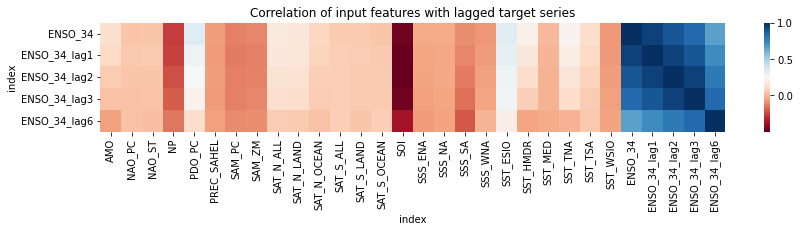

In [128]:
# Plot correlation of inputs and lagged target series as heatmap:
fig, ax = plt.subplots(figsize=(14,2))
plt.title('Correlation of input features with lagged target series')
sns.heatmap(pd.concat([input_FOCI, target_FOCI], axis=1).corr()[-5:], cmap="RdBu", xticklabels=True, yticklabels=True)

### Discussion on correlation check

Find inputs and targets to be **mostly un-correlated**. If at all, we see some minor correlation between PC-based Pacific Decadal Oscillation (PDO_PC) or Eastern Subtropical Indian Ocean sea-surface temperature anomaly (SST_ESIO) and ENSO3.4 index (ENSO_34). Correlation coefficient reads 0.34 and 0.33, respectively.

### Continue data pre-processing

We now continue to prepare inputs and targets:

- Split sequences into samples of specified input length.
- Split inputs and targets into train and validation sets.
- Optionally scale or normalize inputs according to statistics obtained only from train data.

In [203]:
## Set parameters for inputs and target:

# Select input features:
input_features = [
    'AMO', 'NAO_PC', 'NAO_ST', 'NP', 'PDO_PC', 'PREC_SAHEL', 'SAM_PC', 'SAM_ZM', 'SAT_N_ALL', 'SAT_N_LAND',
    'SAT_N_OCEAN', 'SAT_S_ALL', 'SAT_S_LAND', 'SAT_S_OCEAN', 'SOI', 'SSS_ENA', 'SSS_NA', 'SSS_SA', 'SSS_WNA',
    'SST_ESIO', 'SST_HMDR', 'SST_MED', 'SST_TNA', 'SST_TSA', 'SST_WSIO'
]

# Select target:
target_horizon = ['ENSO_34',]

# Specify input length:
input_length = 24  # months

# Specify relative amount of train data:
train_val_split = 0.8

## Optionally choose to scale or normalize input features:
# 'no': Keep raw input features.
# 'scale_01': Scale input features with min/max scaling to [0,1].
# 'scale_11': Scale input features with min/max scaling to [-1,1].
# 'norm': Normalize input features, hence subtract mean and divide by std dev.
scale_norm = 'scale_11' #'norm' #'scale_01'

In [204]:
# Select specified input features:
inputs_selected_FOCI = input_FOCI[input_features]
inputs_selected_CESM = input_CESM[input_features]

# Select target horizon:
target_selected_FOCI = target_FOCI[target_horizon]
target_selected_CESM = target_CESM[target_horizon]

# Split input values into sequences of specified input length:
inputs_split_FOCI = split_sequence(inputs_selected_FOCI, input_length)
inputs_split_CESM = split_sequence(inputs_selected_CESM, input_length)

# Adjust targets: Cut first (input_length - 1) entries:
target_cut_FOCI = target_selected_FOCI[input_length-1:]
target_cut_CESM = target_selected_CESM[input_length-1:]

In [205]:
## Split inputs and targets into train and validation sets:

# Get number of train samples:
n_train = int(train_val_split * len(inputs_split_FOCI))

# Split inputs and targets:
train_input_FOCI = inputs_split_FOCI[:n_train]
train_input_CESM = inputs_split_CESM[:n_train]
val_input_FOCI = inputs_split_FOCI[n_train:]
val_input_CESM = inputs_split_CESM[n_train:]

train_target_FOCI = target_cut_FOCI[:n_train]
train_target_CESM = target_cut_CESM[:n_train]
val_target_FOCI = target_cut_FOCI[n_train:]
val_target_CESM = target_cut_CESM[n_train:]

# Check dimensions:
print("FOCI: train_input shape (samples, time steps, features): ", train_input_FOCI.shape)
print("FOCI_val_input shape (samples, time steps, features): ", val_input_FOCI.shape)
print("CESM: train_input shape (samples, time steps, features): ", train_input_CESM.shape)
print("CESM_val_input shape (samples, time steps, features): ", val_input_CESM.shape)
print("\nFOCI: train_target shape (samples, features): ", train_target_FOCI.shape)
print("FOCI: val_target shape (samples, features): ", val_target_FOCI.shape)
print("CESM train_target shape (samples, features): ", train_target_CESM.shape)
print("CESM: val_target shape (samples, features): ", val_target_CESM.shape)

FOCI: train_input shape (samples, time steps, features):  (9576, 24, 25)
FOCI_val_input shape (samples, time steps, features):  (2395, 24, 25)
CESM: train_input shape (samples, time steps, features):  (9576, 24, 25)
CESM_val_input shape (samples, time steps, features):  (2383, 24, 25)

FOCI: train_target shape (samples, features):  (9576, 1)
FOCI: val_target shape (samples, features):  (2395, 1)
CESM train_target shape (samples, features):  (9576, 1)
CESM: val_target shape (samples, features):  (2383, 1)


In [206]:
## Get statistics from train data:

# Get mean, std dev, min and max for ALL input features from train data:
train_mean_FOCI = np.mean(train_input_FOCI, axis=(0,1))
train_std_FOCI = np.std(train_input_FOCI, axis=(0,1))
train_min_FOCI = np.min(train_input_FOCI, axis=(0,1))
train_max_FOCI = np.max(train_input_FOCI, axis=(0,1))
train_mean_CESM = np.mean(train_input_CESM, axis=(0,1))
train_std_CESM = np.std(train_input_CESM, axis=(0,1))
train_min_CESM = np.min(train_input_CESM, axis=(0,1))
train_max_CESM = np.max(train_input_CESM, axis=(0,1))

## Optionally scale or normalize input features as specified:

# 'scale_01': Scale input features with min/max scaling to [0,1].
if scale_norm == "scale_01":
    train_input_scaled_FOCI = (train_input_FOCI - train_min_FOCI) / (train_max_FOCI - train_min_FOCI)
    val_input_scaled_FOCI = (val_input_FOCI - train_min_FOCI) / (train_max_FOCI - train_min_FOCI)
    train_input_scaled_CESM = (train_input_CESM - train_min_CESM) / (train_max_CESM - train_min_CESM)
    val_input_scaled_CESM = (val_input_CESM - train_min_CESM) / (train_max_CESM - train_min_CESM)

# 'scale_11': Scale input features with min/max scaling to [-1,1].
if scale_norm == "scale_11":
    train_input_scaled_FOCI = 2 * (train_input_FOCI - train_min_FOCI) / (train_max_FOCI - train_min_FOCI) - 1
    val_input_scaled_FOCI = 2 * (val_input_FOCI - train_min_FOCI) / (train_max_FOCI - train_min_FOCI) - 1 
    train_input_scaled_CESM = 2 * (train_input_CESM - train_min_CESM) / (train_max_CESM - train_min_CESM) - 1
    val_input_scaled_CESM = 2 * (val_input_CESM - train_min_CESM) / (train_max_CESM - train_min_CESM) - 1

# 'norm': Normalize input features, hence subtract mean and divide by std dev.
if scale_norm == "norm":
    train_input_scaled_FOCI = (train_input_FOCI - train_mean_FOCI) / train_std_FOCI
    val_input_scaled_FOCI = (val_input_FOCI - train_mean_FOCI) / train_std_FOCI
    train_input_scaled_CESM = (train_input_CESM - train_mean_CESM) / train_std_CESM
    val_input_scaled_CESM = (val_input_CESM - train_mean_CESM) / train_std_CESM

# else: Keep raw input features.

# Check result:
print("FOCI: train_input MIN: ", np.round(np.min(train_input_scaled_FOCI, axis=(0,1)), 2))
print("FOCI: train_input MAX: ", np.round(np.max(train_input_scaled_FOCI, axis=(0,1)), 2))
print("FOCI: train_input MEAN: ", np.round(np.mean(train_input_scaled_FOCI, axis=(0,1)), 2))
print("FOCI: train_input STD: ", np.round(np.std(train_input_scaled_FOCI, axis=(0,1)), 2))
print("FOCI: val_input MIN: ", np.round(np.min(val_input_scaled_FOCI, axis=(0,1)), 2))
print("FOCI: val_input MAX: ", np.round(np.max(val_input_scaled_FOCI, axis=(0,1)), 2))
print("FOCI: val_input MEAN: ", np.round(np.mean(val_input_scaled_FOCI, axis=(0,1)), 2))
print("FOCI: val_input STD: ", np.round(np.std(val_input_scaled_FOCI, axis=(0,1)), 2))
print("\n\nCESM: train_input MIN: ", np.round(np.min(train_input_scaled_CESM, axis=(0,1)), 2))
print("CESM: train_input MAX: ", np.round(np.max(train_input_scaled_CESM, axis=(0,1)), 2))
print("CESM: train_input MEAN: ", np.round(np.mean(train_input_scaled_CESM, axis=(0,1)), 2))
print("CESM: train_input STD: ", np.round(np.std(train_input_scaled_CESM, axis=(0,1)), 2))
print("CESM: val_input MIN: ", np.round(np.min(val_input_scaled_CESM, axis=(0,1)), 2))
print("CESM: val_input MAX: ", np.round(np.max(val_input_scaled_CESM, axis=(0,1)), 2))
print("CESM: val_input MEAN: ", np.round(np.mean(val_input_scaled_CESM, axis=(0,1)), 2))
print("CESM: val_input STD: ", np.round(np.std(val_input_scaled_CESM, axis=(0,1)), 2))

In [ ]:
#### OLD code from notebook 01 ####

In [4]:
# Subtract mean and divide by standard deviation:
climind_FOCI_AMJ = (
    (climind_FOCI_AMJ_mean - np.mean(climind_FOCI_AMJ_mean,axis=0)) / 
    np.std(climind_FOCI_AMJ_mean,axis=0)
)
climind_CESM_AMJ = (
    (climind_CESM_AMJ_mean - np.mean(climind_CESM_AMJ_mean,axis=0)) / 
    np.std(climind_CESM_AMJ_mean,axis=0)
)

## Check result:
# FOCI mean == 0
assert_allclose(
    actual=np.mean(climind_FOCI_AMJ,axis=0).values, 
    desired=np.zeros(len(np.mean(climind_FOCI_AMJ,axis=0).values)), 
    atol=1e-3
)
# FOCI std == 1
assert_allclose(
    actual=np.std(climind_FOCI_AMJ,axis=0).values, 
    desired=np.ones(len(np.mean(climind_FOCI_AMJ,axis=0).values)), 
    atol=1e-3
)
# CESM mean == 0
assert_allclose(
    actual=np.mean(climind_CESM_AMJ,axis=0).values, 
    desired=np.zeros(len(np.mean(climind_CESM_AMJ,axis=0).values)), 
    atol=1e-3
)
# CESM std == 1
assert_allclose(
    actual=np.std(climind_CESM_AMJ,axis=0).values, 
    desired=np.ones(len(np.mean(climind_CESM_AMJ,axis=0).values)), 
    atol=1e-3
)

### Plot target: Sahel Rainfall anomalies JAS (sum)

In [5]:
# Define function to specify bar color, according to sign of values:
def bar_color(data,color_pos,color_neg):
    return np.where(data.values>0,color_pos,color_neg).T

Text(0, 0.5, 'norm. Anomaly (CESM)')

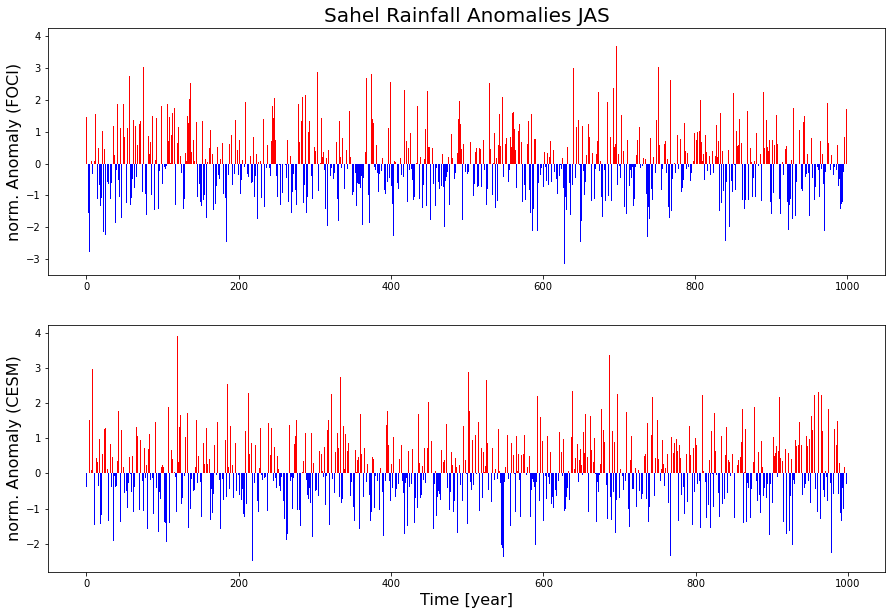

In [6]:
fig, axes = plt.subplots(2,1,figsize=[15,10])
axes[0].bar(
    x=range(len(prec_sahel_FOCI_JAS.values[:,0])),
    height=prec_sahel_FOCI_JAS.values[:,0],
    color=bar_color(prec_sahel_FOCI_JAS,'r','b')[0]
)
axes[1].bar(
    x=range(len(prec_sahel_CESM_JAS.values[:,0])),
    height=prec_sahel_CESM_JAS.values[:,0],
    color=bar_color(prec_sahel_CESM_JAS,'r','b')[0]
)
axes[0].set_title('Sahel Rainfall Anomalies JAS', fontsize=20)
axes[1].set_xlabel('Time [year]', fontsize=16)
axes[0].set_ylabel('norm. Anomaly (FOCI)', fontsize=16)
axes[1].set_ylabel('norm. Anomaly (CESM)', fontsize=16)

### Prepare inputs and targets

In [131]:
## Split inputs and targets into train and validation sets (80:20):

# Get split point:
split = int(len(climind_FOCI_AMJ) * 0.8)

train_input_FOCI = climind_FOCI_AMJ[:split]
val_input_FOCI = climind_FOCI_AMJ[split:]
train_input_CESM = climind_CESM_AMJ[:split]
val_input_CESM = climind_CESM_AMJ[split:]

train_target_FOCI = prec_sahel_FOCI_JAS[:split]
val_target_FOCI = prec_sahel_FOCI_JAS[split:]
train_target_CESM = prec_sahel_CESM_JAS[:split]
val_target_CESM = prec_sahel_CESM_JAS[split:]

# Check dimensions:
print("train_input_FOCI shape (samples, features): ", train_input_FOCI.shape)
print("train_input_CESM shape (samples, features): ", train_input_CESM.shape)
print("val_input_FOCI shape (samples, features): ", val_input_FOCI.shape)
print("val_input_CESM shape (samples, features): ", val_input_CESM.shape)
print("\ntrain_target_FOCI shape (samples, features): ", train_target_FOCI.shape)
print("train_target_CESM shape (samples, features): ", train_target_CESM.shape)
print("val_target_FOCI shape (samples, features): ", val_target_FOCI.shape)
print("val_target_CESM shape (samples, features): ", val_target_CESM.shape)

train_input_FOCI shape (samples, features):  (800, 28)
train_input_CESM shape (samples, features):  (800, 28)
val_input_FOCI shape (samples, features):  (200, 28)
val_input_CESM shape (samples, features):  (199, 28)

train_target_FOCI shape (samples, features):  (800, 1)
train_target_CESM shape (samples, features):  (800, 1)
val_target_FOCI shape (samples, features):  (200, 1)
val_target_CESM shape (samples, features):  (199, 1)


In [130]:
# Optionally pick a reduced set of input features to train the models:
# train_input_FOCI = train_input_FOCI[['SAT_N_ALL', 'SAT_N_LAND', 'SAT_N_OCEAN']]
# val_input_FOCI = val_input_FOCI[['SAT_N_ALL', 'SAT_N_LAND', 'SAT_N_OCEAN']]

### Try linear regression to set the benchmark

#### Nomenclature and mathematical background on linear regression

We apply multi-linear regression and use **April to June mean index values as predictors** to predict **July to September seasonal sum of Sahel precipitation anomaly index**. 

Inputs have dimension (samples, features), targets have timension (samples, 1). We are looking for weights $W$ with shape (features, 1) and bias $b$ as single value.

The relation between train inputs $U$, weights, bias and train targets $Y$ reads:

$$U \cdot W + \overline{b} = Y$$

Note: Here $\overline{b}$ denotes a vector of shape (samples, 1), containing only the single output bias value $b$.

We switch to "augmented" notation and include ${b}$ as additional weight in $W$. This requires to add a column of *ones* as last column of $U$, for keeping dimensions right. This leads to:

$$U' \cdot W' = Y$$

where $U'$ and $W'$ denote train inputs and weights in augmented notation, respectively. 

Solving for $W'$ we need to invert $U'$, or get the pseudo-inverse $U'_{inv}$, since $U'$ is usually not a square matrix:

$$W' = U'_{inv} \cdot Y$$

Doing this, we obtain trained weights (including bias) and stick to augmented notation. To get predictions on validation inputs we also need to add a column of *ones* as last column to validation inputs.

In [132]:
### Linear regression on FOCI data

# Create vector of shape (samples, 1) containing ONEs to be added as additional column to train and val inputs.
train_input_add = np.ones((train_input_FOCI.shape[0], 1))
val_input_add = np.ones((val_input_FOCI.shape[0], 1))

# Now add vector of ONEs as additional column to train and validation inputs, omit time dimension:
train_input_prime = np.concatenate((train_input_FOCI.values[:,:], train_input_add), axis=-1)
val_input_prime = np.concatenate((val_input_FOCI.values[:,:], val_input_add), axis=-1)

# Then need pseudo-inverse of train inputs in augmented notation
train_input_prime_inv = np.linalg.pinv(train_input_prime)

# Then get output weights, in augmented notation
W_prime = np.matmul(train_input_prime_inv, train_target_FOCI.values)

# Now extract weights and bias from augmented notation (W_prime), the last value is the bias:
W = W_prime[:-1,0]
b = W_prime[-1,0]

## Get model predictions on train and validation data:
train_pred_linReg_FOCI = np.matmul(train_input_prime, W_prime)
val_pred_linReg_FOCI = np.matmul(val_input_prime, W_prime)

Text(0, 0.5, 'norm. Anomaly (FOCI)')

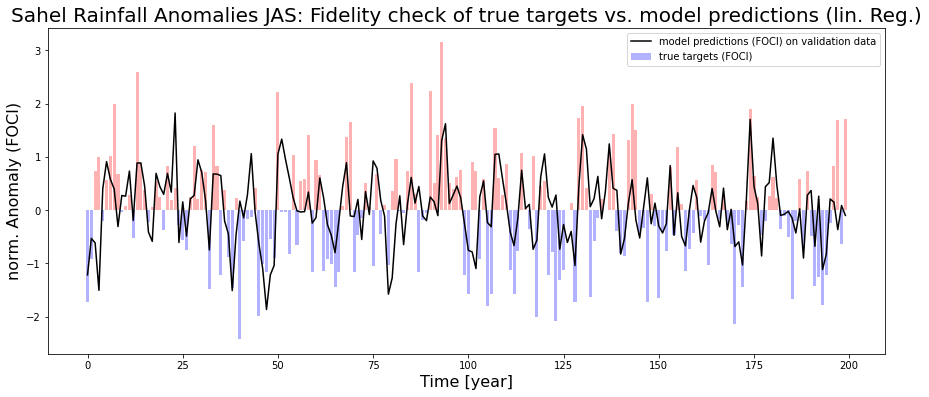

In [133]:
# Fidelity check: Plot VALIDATION targets as bar plot (red / blue) vs. predictions as black line (FOCI)
fig, ax = plt.subplots(1,1,figsize=[15,6])
ax.bar(
    x=range(len(prec_sahel_FOCI_JAS.values[split:,0])),
    height=prec_sahel_FOCI_JAS.values[split:,0],
    color=bar_color(prec_sahel_FOCI_JAS[split:],'r','b')[0],
    label="true targets (FOCI)",
    alpha=0.3
)
ax.plot(val_pred_linReg_FOCI, label="model predictions (FOCI) on validation data", color='black')
ax.legend()
ax.set_title('Sahel Rainfall Anomalies JAS: Fidelity check of true targets vs. model predictions (lin. Reg.)', fontsize=20)
ax.set_xlabel('Time [year]', fontsize=16)
ax.set_ylabel('norm. Anomaly (FOCI)', fontsize=16)

In [134]:
# Check loss (mse) of true targets vs. model predictions:
print("Mean-squared error on train data (FOCI) with lin. Reg.: ", 
      np.round(np.mean((train_pred_linReg_FOCI[:,0] - train_target_FOCI.values[:,0])**2),3))
print("Mean-squared error on validation data (FOCI) with lin. Reg.: ", 
      np.round(np.mean((val_pred_linReg_FOCI[:,0] - val_target_FOCI.values[:,0])**2),3))

# Check correlation of true targets and model predictions:
print("\nCorrelation on train data (FOCI) with lin. Reg.: ",
      np.round(np.corrcoef(np.stack([train_pred_linReg_FOCI[:,0], train_target_FOCI.values[:,0]]))[0,1],3)
     )
print("Correlation on validation data (FOCI) with lin. Reg.: ",
      np.round(np.corrcoef(np.stack([val_pred_linReg_FOCI[:,0], val_target_FOCI.values[:,0]]))[0,1],3)
     )

Mean-squared error on train data (FOCI) with lin. Reg.:  0.864
Mean-squared error on validation data (FOCI) with lin. Reg.:  0.827

Correlation on train data (FOCI) with lin. Reg.:  0.547
Correlation on validation data (FOCI) with lin. Reg.:  0.496


### Set up multi-layer perceptron (MLP) for single run experiments on FOCI and CESM data

In [135]:
# Define customized metric function to compute Pearson's correlation coefficient 
# on true targets and model predictions.

def correlation_coefficient(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    sx = K.std(x)
    sy = K.std(y)
    xm, ym = x-mx, y-my
    r = K.mean(xm * ym) / (sx * sy)
    return r

Model: "MLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 28)]              0         
_________________________________________________________________
dense_18 (Dense)             (None, 20)                580       
_________________________________________________________________
dense_19 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 11        
Total params: 801
Trainable params: 801
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
80/80 - 0s - loss: 2.9714 - correlation_coefficient: 0.2016 - val_loss: 1.6615 - val_correlation_coefficient: 0.3306
Epoch 2/10
80/80 - 0s - loss: 1.4458 - correlation_coefficient: 0.2942 - val_loss: 1.1753 - val_correlation_coefficient: 0.3811
Epoch 3

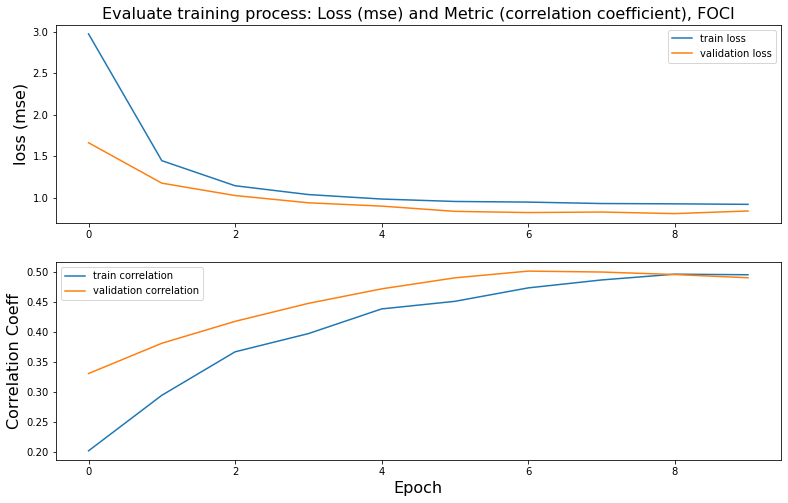

In [136]:
## Set parameters upfront:
lr = 0.0005 # Learning rate
epc = 10 # Number of epochs
batch_size = 10 # Batch size
in_features = train_input_FOCI.shape[1] # Number of input features

# Set up layers:
inputs = Input(shape=(in_features))
hidden_1 = Dense(20, activation='linear')(inputs)
hidden_2 = Dense(10, activation='linear')(hidden_1)
output = Dense(1, activation='linear')(hidden_2)

## Alternatively try more hidden layers with ReLU activation:
# # Set up layers:
# inputs = Input(shape=(in_features))
# hidden_1 = Dense(30, activation='relu')(inputs)
# hidden_2 = Dense(30, activation='relu')(hidden_1)
# hidden_3 = Dense(30, activation='relu')(hidden_2)
# hidden_4 = Dense(30, activation='relu')(hidden_3)
# output = Dense(1, activation='linear')(hidden_4)

# Define and compile model :
model_MLP = Model(inputs, output, name='MLP')
opt = Adam(lr=lr) #SGD(lr=lr)
model_MLP.compile(loss='mse', optimizer=opt, metrics=[correlation_coefficient])
model_MLP.summary()

## train model on FOCI data:
history = model_MLP.fit(train_input_FOCI, train_target_FOCI, epochs=epc, verbose=2, shuffle=True,
                    batch_size=batch_size, validation_data=(val_input_FOCI, val_target_FOCI))

# Plot loss (mse) and metric (correlation coefficient) on train and validation data (FOCI):
fig, axes = plt.subplots(2, 1, figsize=(13,8))
axes[0].set_title("Evaluate training process: Loss (mse) and Metric (correlation coefficient), FOCI", fontsize=16)
axes[0].plot(history.history['loss'], label='train loss'), 
axes[0].plot(history.history['val_loss'], label='validation loss')
axes[0].set_ylabel("loss (mse)", fontsize=16)
axes[0].legend()
axes[1].plot(history.history['correlation_coefficient'], label='train correlation'), 
axes[1].plot(history.history['val_correlation_coefficient'], label='validation correlation')
axes[1].set_ylabel("Correlation Coeff", fontsize=16)
axes[1].legend()
axes[1].set_xlabel("Epoch", fontsize=16)
plt.show()

## Get model predictions on train and validation data:
train_pred_MLP_FOCI = model_MLP.predict(train_input_FOCI)
val_pred_MLP_FOCI = model_MLP.predict(val_input_FOCI)

Text(0, 0.5, 'norm. Anomaly (FOCI)')

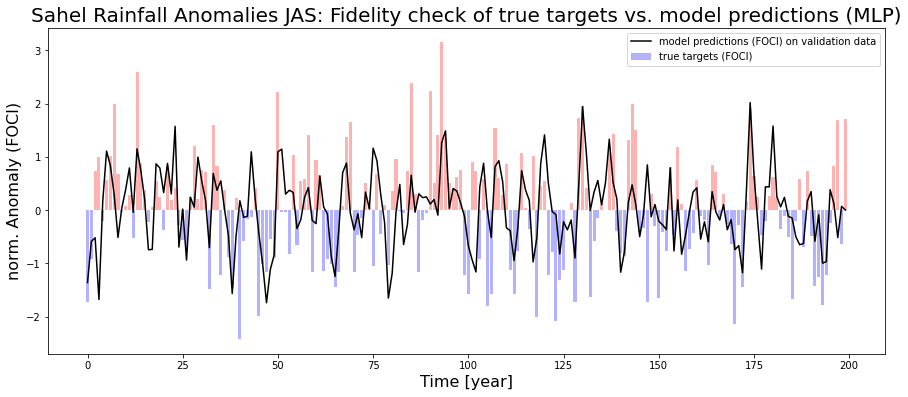

In [137]:
# Fidelity check: Plot VALIDATION targets as bar plot (red / blue) vs. predictions as black line (FOCI)
fig, ax = plt.subplots(1,1,figsize=[15,6])
ax.bar(
    x=range(len(prec_sahel_FOCI_JAS.values[split:,0])),
    height=prec_sahel_FOCI_JAS.values[split:,0],
    color=bar_color(prec_sahel_FOCI_JAS[split:],'r','b')[0],
    label="true targets (FOCI)",
    alpha=0.3
)
ax.plot(val_pred_MLP_FOCI, label="model predictions (FOCI) on validation data", color='black')
ax.legend()
ax.set_title('Sahel Rainfall Anomalies JAS: Fidelity check of true targets vs. model predictions (MLP)', fontsize=20)
ax.set_xlabel('Time [year]', fontsize=16)
ax.set_ylabel('norm. Anomaly (FOCI)', fontsize=16)

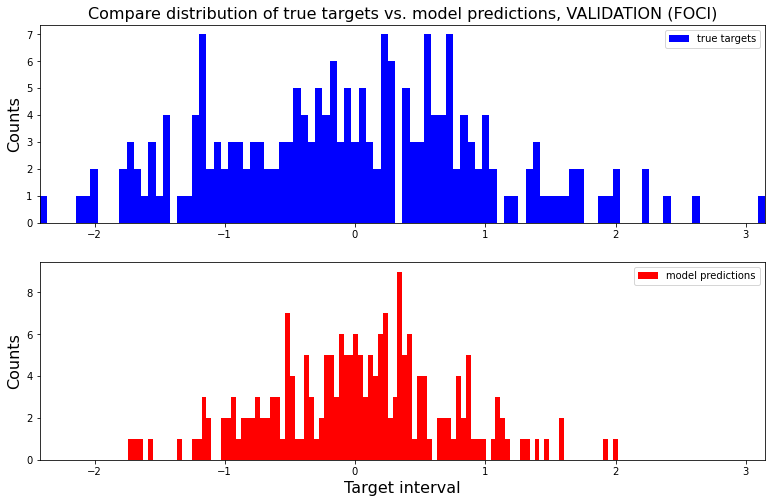

In [138]:
# Plot histogram of true targets and predictions (FOCI)
nBins = 100
fig, axes = plt.subplots(2, 1, figsize=(13,8))
axes[0].hist(val_target_FOCI.values[:,0], nBins, color="blue", label="true targets")
axes[0].set_ylabel("Counts", fontsize=16)
axes[0].legend()
axes[0].set_xlim(left=min(val_target_FOCI.values[:,0]), right=max(val_target_FOCI.values[:,0]))
axes[1].hist(val_pred_MLP_FOCI[:,0], nBins, color="red", label="model predictions")
axes[1].set_ylabel("Counts", fontsize=16)
axes[1].legend()
axes[1].set_xlim(left=min(val_target_FOCI.values[:,0]), right=max(val_target_FOCI.values[:,0]))
axes[1].set_xlabel("Target interval", fontsize=16)
axes[0].set_title("Compare distribution of true targets vs. model predictions, VALIDATION (FOCI)", fontsize=16)
plt.show()

In [139]:
## Results from MLP model:

# Check loss (mse) of true targets vs. model predictions:
print("MLP:\n====\nMean-squared error on train data (FOCI) with MLP: ", 
      np.round(np.mean((train_pred_MLP_FOCI[:,0] - train_target_FOCI.values[:,0])**2),3))
print("Mean-squared error on validation data (FOCI) with MLP: ", 
      np.round(np.mean((val_pred_MLP_FOCI[:,0] - val_target_FOCI.values[:,0])**2),3))

# Check correlation of true targets and model predictions:
print("\nCorrelation on train data (FOCI) with MLP: ",
      np.round(np.corrcoef(np.stack([train_pred_MLP_FOCI[:,0], train_target_FOCI.values[:,0]]))[0,1],3)
     )
print("Correlation on validation data (FOCI) with MLP: ",
      np.round(np.corrcoef(np.stack([val_pred_MLP_FOCI[:,0], val_target_FOCI.values[:,0]]))[0,1],3)
     )

## Compare with benchmark results from lin. Regression

# Check loss (mse) of true targets vs. model predictions:
print("\n\nlin. Regression:\n================\nMean-squared error on train data (FOCI) with lin. Reg.: ", 
      np.round(np.mean((train_pred_linReg_FOCI[:,0] - train_target_FOCI.values[:,0])**2),3))
print("Mean-squared error on validation data (FOCI) with lin. Reg.: ", 
      np.round(np.mean((val_pred_linReg_FOCI[:,0] - val_target_FOCI.values[:,0])**2),3))

# Check correlation of true targets and model predictions:
print("\nCorrelation on train data (FOCI) with lin. Reg.: ",
      np.round(np.corrcoef(np.stack([train_pred_linReg_FOCI[:,0], train_target_FOCI.values[:,0]]))[0,1],3)
     )
print("Correlation on validation data (FOCI) with lin. Reg.: ",
      np.round(np.corrcoef(np.stack([val_pred_linReg_FOCI[:,0], val_target_FOCI.values[:,0]]))[0,1],3)
     )

MLP:
====
Mean-squared error on train data (FOCI) with MLP:  0.906
Mean-squared error on validation data (FOCI) with MLP:  0.84

Correlation on train data (FOCI) with MLP:  0.519
Correlation on validation data (FOCI) with MLP:  0.494


lin. Regression:
Mean-squared error on train data (FOCI) with lin. Reg.:  0.864
Mean-squared error on validation data (FOCI) with lin. Reg.:  0.827

Correlation on train data (FOCI) with lin. Reg.:  0.547
Correlation on validation data (FOCI) with lin. Reg.:  0.496


In [140]:
# Check correlation of predictions from MLP and lin. regression (FOCI):
print("Correlation of predictions on train data from MLP and lin. Reg. (FOCI): ",
      np.round(np.corrcoef(np.stack([train_pred_linReg_FOCI[:,0], train_pred_MLP_FOCI[:,0]]))[0,1],3)
     )
print("Correlation of predictions on validation data from MLP and lin. Reg. (FOCI): ",
      np.round(np.corrcoef(np.stack([val_pred_linReg_FOCI[:,0], val_pred_MLP_FOCI[:,0]]))[0,1],3)
     )

Correlation of predictions on train data from MLP and lin. Reg. (FOCI):  0.948
Correlation of predictions on validation data from MLP and lin. Reg. (FOCI):  0.955


### Compare results from single-run experiment with MLP to predict Sahel Rainfall with benchmark (lin. Reg.)

#### Setup
- In this experiment we used all indices from our CICMoD dataset as predictors, except Sahel Rainfall anomaly ("PREC_SAHEL"), since it was used as target.
- All input indicies have then been normalized to have zero mean and unit variance.

#### Experiment
- Tried multi-linear regression to set the benchmark.
- Then trained multi-layer perceptron with two hidden layers with mean-squared-error loss and tracked correlation coefficient of true targets and model predictions as customized metric.

#### Results
Started to train both models - linear regression and MLP - on FOCI data. The MLP model is found to train well, no signs of overfitting. Adding additional hidden layers didn't improve model performance, but only forced the model to overfit on train data. Find somewhat poor correlation of about 50% on both - train and validation data, compared to [Badr et al., 2014], who show 81% / 71% correlation on real-world train and validation data, respectively.

And our MLP model is not able to beat the benchmark: Linear regression performs slightly better. However, find the correlation between predictions from both models to be quite high (close to 1).

#### Next steps
- Try to train model on CESM data.
- Try to cross models an data: Can we train a model on e.g. FOCI data and apply it to CESM data?
- Perform multi-run experiments to optimize model (hyper-)parameters.

### Layer-wise relevance propagation with MLP compared to largest absolute weights from lin. regression

For a moment skip the *next steps* outlined above and directly try to find out, which input features are most relevant for both models:

- For our linear regression model we can investigate the trained weights and plot them in ascending order.
- For the MLP model we apply layer-wise relevance propagation.

([<matplotlib.axis.XTick at 0x1bada6a90>,
 [Text(0, 0, 'SAT_N_LAND'),
  Text(1, 0, 'SAT_N_OCEAN'),
  Text(2, 0, 'SAT_S_OCEAN'),
  Text(3, 0, 'SAT_S_LAND'),
  Text(4, 0, 'ENSO_34'),
  Text(5, 0, 'SST_TSA'),
  Text(6, 0, 'ENSO_4'),
  Text(7, 0, 'SST_HMDR'),
  Text(8, 0, 'NAO_PC'),
  Text(9, 0, 'ENSO_12'),
  Text(10, 0, 'SSS_ENA'),
  Text(11, 0, 'SOI'),
  Text(12, 0, 'SAM_ZM'),
  Text(13, 0, 'SST_WSIO'),
  Text(14, 0, 'SAM_PC'),
  Text(15, 0, 'SSS_NA'),
  Text(16, 0, 'SST_ESIO'),
  Text(17, 0, 'PDO_PC'),
  Text(18, 0, 'NP'),
  Text(19, 0, 'SSS_WNA'),
  Text(20, 0, 'SSS_SA'),
  Text(21, 0, 'NAO_ST'),
  Text(22, 0, 'SST_MED'),
  Text(23, 0, 'SST_TNA'),
  Text(24, 0, 'AMO'),
  Text(25, 0, 'ENSO_3'),
  Text(26, 0, 'SAT_S_ALL'),
  Text(27, 0, 'SAT_N_ALL')])

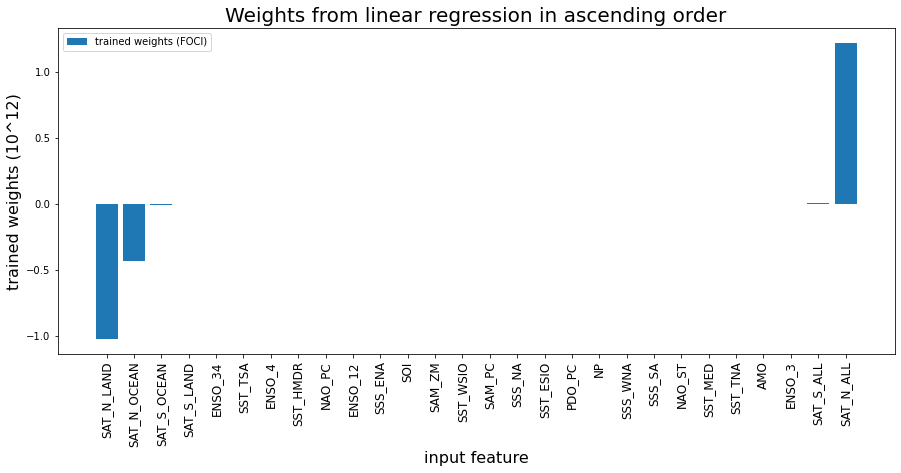

In [107]:
# Check trained weights from linear regression in ascending order:
fig, ax = plt.subplots(1,1,figsize=[15,6])
ax.bar(
    x=range(len(W)),
    height=W[np.argsort(W)]/1e12,
    label="trained weights (FOCI)",
)
ax.legend()
ax.set_title('Weights from linear regression in ascending order', fontsize=20)
ax.set_xlabel('input feature', fontsize=16)
ax.set_ylabel('trained weights (10^12)', fontsize=16)
plt.xticks(range(len(W)), train_input_FOCI.columns.values[np.argsort(W)], fontsize=12, rotation=90)

In [190]:
### LRP with MLP on TRAIN samples (FOCI) with POSITIVE target:

## Split train inputs according to target:
samples_pos = train_input_FOCI.values[(train_target_FOCI.values>0)[:,0]]

# Extract number of input features:
in_feat = samples_pos.shape[1]

### Extract model weights from trained model:

## Get all weights:
model_weights = np.array(model_MLP.get_weights())

## Set input / hidden / output weights and bias(es):
W_in = model_weights[0]
b_in = model_weights[1]
W_hidden = model_weights[2]
b_hidden = model_weights[3]
W_out = model_weights[4]
b_out = model_weights[5]

## Initialize storage for mean relevance over all samples with positive target with correct dimensions:
R_all_pos = np.zeros(samples_pos.shape)

/var/folders/jv/p__lpnd50w93ff78f84hkwkh7fs9_f/T/ipykernel_1465/298401471.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  model_weights = np.array(model_MLP.get_weights())


In [191]:
#Loop over samples with positive target:
for sample_id in range(len(samples_pos)):
    
    # Print status:
    print ("sample: ", sample_id+1, " from ", len(samples_pos))
    
    # Get current sample:
    sample = samples_pos[sample_id:sample_id+1,:]
    
    # Have trained model as pre-requisite. Check prediction and target on picked sample:
    pred = model_MLP.predict(sample)[0,0]

    ## Get outputs from first and second hidden layer, X_1 and X_2, respectively:

    # Define shortened models:
    model_X1 = Model(inputs, hidden_1, name='model_X1')
    model_X2 = Model(inputs, hidden_2, name='model_X2')

    # Get outputs on selected sample (forward-pass) from trained short models:
    X_1 = model_X1.predict(sample)[0]
    X_2 = model_X2.predict(sample)[0]

    # Get inputs U from raw input sample by just omitting first dimension (=sample number):
    U = sample[0,:]
    
    
    ## LRP: Only consider POSITIVE pre-activations for propagation rule.
  
    ## Start with connection of second HIDDEN layer (X_2) to single OUTPUT unit.
    R_i = ((np.multiply(X_2,W_out[:,0])>0) * np.multiply(X_2,W_out[:,0]) /
           sum((np.multiply(X_2,W_out[:,0])>0) * np.multiply(X_2,W_out[:,0]))) * abs(pred)

    # Continue with connection of first HIDDEN layer (X_1) to second HIDDEN layer (X_2).
    R_j = np.sum(((np.multiply(np.reshape(X_1, (len(X_1),1)),W_hidden)>0) * np.multiply(np.reshape(X_1, (len(X_1),1)),W_hidden) /
           np.sum((np.multiply(np.reshape(X_1, (len(X_1),1)),W_hidden)>0) * np.multiply(np.reshape(X_1, (len(X_1),1)),W_hidden),axis=0)) * R_i, axis=1)

    # And then take care about connection of INPUT layer to first HIDDEN layer (X_1).
    R_k = np.sum(((np.multiply(np.reshape(U, (in_feat,1)), W_in)>0) * np.multiply(np.reshape(U, (in_feat,1)), W_in) / 
                  np.sum((np.multiply(np.reshape(U, (in_feat,1)), W_in)>0) * np.multiply(np.reshape(U, (in_feat,1)), W_in),axis=0)) * R_j, axis=1)

    # Normalize relevance map to have sum of total relevance equal to ONE.
    # Simply divide by absolute prediction, which served as total relevance to start with:
    R_k /= abs(pred)

    # Store relevance for current sample:
    R_all_pos[sample_id,:] = R_k
    
# Get mean relevance for all samples with positive target for all input features:
R_all_mean_pos = np.mean(R_all_pos,axis=0)

sample:  1  from  377
sample:  2  from  377
sample:  3  from  377
sample:  4  from  377
sample:  5  from  377
sample:  6  from  377


sample:  7  from  377
sample:  8  from  377
sample:  9  from  377
sample:  10  from  377
sample:  11  from  377
sample:  12  from  377


sample:  13  from  377
sample:  14  from  377
sample:  15  from  377
sample:  16  from  377
sample:  17  from  377


sample:  18  from  377
sample:  19  from  377
sample:  20  from  377
sample:  21  from  377
sample:  22  from  377
sample:  23  from  377


sample:  24  from  377
sample:  25  from  377
sample:  26  from  377
sample:  27  from  377
sample:  28  from  377
sample:  29  from  377


sample:  30  from  377
sample:  31  from  377
sample:  32  from  377
sample:  33  from  377
sample:  34  from  377


sample:  35  from  377
sample:  36  from  377
sample:  37  from  377
sample:  38  from  377
sample:  39  from  377
sample:  40  from  377


sample:  41  from  377
sample:  42  from  377
sample:  43  from  377
sample:  44  from  377
sample:  45  from  377
sample:  46  from  377


sample:  47  from  377
sample:  48  from  377
sample:  49  from  377
sample:  50  from  377
sample:  51  from  377


sample:  52  from  377
sample:  53  from  377
sample:  54  from  377
sample:  55  from  377
sample:  56  from  377
sample:  57  from  377


sample:  58  from  377
sample:  59  from  377
sample:  60  from  377
sample:  61  from  377
sample:  62  from  377
sample:  63  from  377


sample:  64  from  377
sample:  65  from  377
sample:  66  from  377
sample:  67  from  377
sample:  68  from  377


sample:  69  from  377
sample:  70  from  377
sample:  71  from  377
sample:  72  from  377
sample:  73  from  377
sample:  74  from  377


sample:  75  from  377
sample:  76  from  377
sample:  77  from  377
sample:  78  from  377
sample:  79  from  377
sample:  80  from  377


sample:  81  from  377
sample:  82  from  377
sample:  83  from  377
sample:  84  from  377
sample:  85  from  377


sample:  86  from  377
sample:  87  from  377
sample:  88  from  377
sample:  89  from  377
sample:  90  from  377
sample:  91  from  377


sample:  92  from  377
sample:  93  from  377
sample:  94  from  377
sample:  95  from  377
sample:  96  from  377
sample:  97  from  377


sample:  98  from  377
sample:  99  from  377
sample:  100  from  377
sample:  101  from  377
sample:  102  from  377


sample:  103  from  377
sample:  104  from  377
sample:  105  from  377
sample:  106  from  377
sample:  107  from  377
sample:  108  from  377


sample:  109  from  377
sample:  110  from  377
sample:  111  from  377
sample:  112  from  377
sample:  113  from  377


sample:  114  from  377
sample:  115  from  377
sample:  116  from  377
sample:  117  from  377
sample:  118  from  377
sample:  119  from  377


sample:  120  from  377
sample:  121  from  377
sample:  122  from  377
sample:  123  from  377
sample:  124  from  377


sample:  125  from  377
sample:  126  from  377
sample:  127  from  377
sample:  128  from  377
sample:  129  from  377
sample:  130  from  377


sample:  131  from  377
sample:  132  from  377
sample:  133  from  377
sample:  134  from  377
sample:  135  from  377


sample:  136  from  377
sample:  137  from  377
sample:  138  from  377
sample:  139  from  377
sample:  140  from  377
sample:  141  from  377


sample:  142  from  377
sample:  143  from  377
sample:  144  from  377
sample:  145  from  377
sample:  146  from  377


sample:  147  from  377
sample:  148  from  377
sample:  149  from  377
sample:  150  from  377
sample:  151  from  377
sample:  152  from  377


sample:  153  from  377
sample:  154  from  377
sample:  155  from  377
sample:  156  from  377
sample:  157  from  377


sample:  158  from  377
sample:  159  from  377
sample:  160  from  377
sample:  161  from  377
sample:  162  from  377
sample:  163  from  377


sample:  164  from  377
sample:  165  from  377
sample:  166  from  377
sample:  167  from  377
sample:  168  from  377


sample:  169  from  377
sample:  170  from  377
sample:  171  from  377
sample:  172  from  377
sample:  173  from  377
sample:  174  from  377


sample:  175  from  377
sample:  176  from  377
sample:  177  from  377
sample:  178  from  377
sample:  179  from  377


sample:  180  from  377
sample:  181  from  377
sample:  182  from  377
sample:  183  from  377
sample:  184  from  377
sample:  185  from  377


sample:  186  from  377
sample:  187  from  377
sample:  188  from  377
sample:  189  from  377
sample:  190  from  377


sample:  191  from  377
sample:  192  from  377
sample:  193  from  377
sample:  194  from  377
sample:  195  from  377
sample:  196  from  377


sample:  197  from  377
sample:  198  from  377
sample:  199  from  377
sample:  200  from  377
sample:  201  from  377


sample:  202  from  377
sample:  203  from  377
sample:  204  from  377
sample:  205  from  377
sample:  206  from  377
sample:  207  from  377


sample:  208  from  377
sample:  209  from  377
sample:  210  from  377
sample:  211  from  377
sample:  212  from  377


sample:  213  from  377
sample:  214  from  377
sample:  215  from  377
sample:  216  from  377
sample:  217  from  377
sample:  218  from  377


sample:  219  from  377
sample:  220  from  377
sample:  221  from  377
sample:  222  from  377
sample:  223  from  377


sample:  224  from  377
sample:  225  from  377
sample:  226  from  377
sample:  227  from  377
sample:  228  from  377
sample:  229  from  377


sample:  230  from  377
sample:  231  from  377
sample:  232  from  377
sample:  233  from  377
sample:  234  from  377


sample:  235  from  377
sample:  236  from  377
sample:  237  from  377
sample:  238  from  377
sample:  239  from  377
sample:  240  from  377


sample:  241  from  377
sample:  242  from  377
sample:  243  from  377
sample:  244  from  377
sample:  245  from  377


sample:  246  from  377
sample:  247  from  377
sample:  248  from  377
sample:  249  from  377
sample:  250  from  377
sample:  251  from  377


sample:  252  from  377
sample:  253  from  377
sample:  254  from  377
sample:  255  from  377
sample:  256  from  377


sample:  257  from  377
sample:  258  from  377
sample:  259  from  377
sample:  260  from  377
sample:  261  from  377
sample:  262  from  377


sample:  263  from  377
sample:  264  from  377
sample:  265  from  377
sample:  266  from  377
sample:  267  from  377


sample:  268  from  377
sample:  269  from  377
sample:  270  from  377
sample:  271  from  377
sample:  272  from  377
sample:  273  from  377


sample:  274  from  377
sample:  275  from  377
sample:  276  from  377
sample:  277  from  377
sample:  278  from  377


sample:  279  from  377
sample:  280  from  377
sample:  281  from  377
sample:  282  from  377
sample:  283  from  377
sample:  284  from  377


sample:  285  from  377
sample:  286  from  377
sample:  287  from  377
sample:  288  from  377
sample:  289  from  377


sample:  290  from  377
sample:  291  from  377
sample:  292  from  377
sample:  293  from  377
sample:  294  from  377
sample:  295  from  377


sample:  296  from  377
sample:  297  from  377
sample:  298  from  377
sample:  299  from  377
sample:  300  from  377


sample:  301  from  377
sample:  302  from  377
sample:  303  from  377
sample:  304  from  377
sample:  305  from  377
sample:  306  from  377


sample:  307  from  377
sample:  308  from  377
sample:  309  from  377
sample:  310  from  377
sample:  311  from  377


sample:  312  from  377
sample:  313  from  377
sample:  314  from  377
sample:  315  from  377
sample:  316  from  377
sample:  317  from  377


sample:  318  from  377
sample:  319  from  377
sample:  320  from  377
sample:  321  from  377
sample:  322  from  377


sample:  323  from  377
sample:  324  from  377
sample:  325  from  377
sample:  326  from  377
sample:  327  from  377
sample:  328  from  377


sample:  329  from  377
sample:  330  from  377
sample:  331  from  377
sample:  332  from  377
sample:  333  from  377


sample:  334  from  377
sample:  335  from  377
sample:  336  from  377
sample:  337  from  377
sample:  338  from  377
sample:  339  from  377


sample:  340  from  377
sample:  341  from  377
sample:  342  from  377
sample:  343  from  377
sample:  344  from  377


sample:  345  from  377
sample:  346  from  377
sample:  347  from  377
sample:  348  from  377
sample:  349  from  377
sample:  350  from  377


sample:  351  from  377
sample:  352  from  377
sample:  353  from  377
sample:  354  from  377
sample:  355  from  377


sample:  356  from  377
sample:  357  from  377
sample:  358  from  377
sample:  359  from  377
sample:  360  from  377
sample:  361  from  377


sample:  362  from  377
sample:  363  from  377
sample:  364  from  377
sample:  365  from  377
sample:  366  from  377


sample:  367  from  377
sample:  368  from  377
sample:  369  from  377
sample:  370  from  377
sample:  371  from  377
sample:  372  from  377


sample:  373  from  377
sample:  374  from  377
sample:  375  from  377
sample:  376  from  377
sample:  377  from  377


([<matplotlib.axis.XTick at 0x1bca1be80>,
 [Text(0, 0, 'ENSO_34'),
  Text(1, 0, 'ENSO_12'),
  Text(2, 0, 'SAT_S_LAND'),
  Text(3, 0, 'SAT_S_OCEAN'),
  Text(4, 0, 'SST_TSA'),
  Text(5, 0, 'SAT_N_ALL'),
  Text(6, 0, 'SST_TNA'),
  Text(7, 0, 'SSS_NA'),
  Text(8, 0, 'AMO'),
  Text(9, 0, 'SOI'),
  Text(10, 0, 'PDO_PC'),
  Text(11, 0, 'SAM_ZM'),
  Text(12, 0, 'SSS_WNA'),
  Text(13, 0, 'SAM_PC'),
  Text(14, 0, 'SSS_ENA'),
  Text(15, 0, 'NAO_ST'),
  Text(16, 0, 'SAT_N_OCEAN'),
  Text(17, 0, 'SAT_N_LAND'),
  Text(18, 0, 'ENSO_3'),
  Text(19, 0, 'SST_WSIO'),
  Text(20, 0, 'ENSO_4'),
  Text(21, 0, 'NAO_PC'),
  Text(22, 0, 'NP'),
  Text(23, 0, 'SST_MED'),
  Text(24, 0, 'SST_ESIO'),
  Text(25, 0, 'SST_HMDR'),
  Text(26, 0, 'SAT_S_ALL'),
  Text(27, 0, 'SSS_SA')])

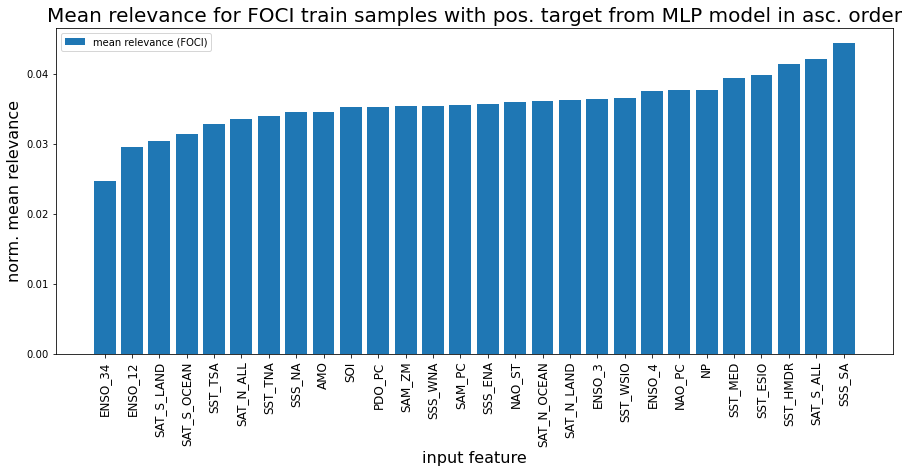

In [204]:
# Check relevance for all input features from MLP model in ascending order:
fig, ax = plt.subplots(1,1,figsize=[15,6])
ax.bar(
    x=range(len(R_all_mean_pos)),
    height=R_all_mean_pos[np.argsort(R_all_mean_pos)],
    label="mean relevance (FOCI)",
)
ax.legend()
ax.set_title('Mean relevance for FOCI train samples with pos. target from MLP model in asc. order', fontsize=20)
ax.set_xlabel('input feature', fontsize=16)
ax.set_ylabel('norm. mean relevance', fontsize=16)
plt.xticks(range(len(R_all_mean_pos)), train_input_FOCI.columns.values[np.argsort(R_all_mean_pos)], fontsize=12, rotation=90)

### Discussion on relevant input features

Find largest *absolute* values among trained weights from **linear regression** for sea air temperature (SAT) anomalies in the Northern Hemisphere. But that doesn't mean, that the model puts its focus mostly on these pedictors: Trained only on 'SAT_N_ALL', 'SAT_N_LAND' and 'SAT_N_OCEAN' both - MLP and linear regression - fail! And surprisingly sea-surface salinity (SSS) anomalies only get small weights in linear regression model. Would have expected SSS to play a bigger role for predicting Sahel Rainfall.

Mean relevance for all input features from **MLP model** on FOCI samples with positive targets show highest relevance for one of the SSS features, followed by an SAT feature and several sea-surface temperature (SST) anomalies. That appears to be more reasonable - on the first sight.

#### Next steps:

- Get mean relevance for samples with negative targets.
- Try also for MLP model trained on CESM samples.